In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# Getting ideal rho

In [3]:
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

"""
Define basis in to be used when doing MLE
"""
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [4]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
psi_basis_3q = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
S123 = 'ZZZ'
S1, S2, S3 = S123
psi1 = psi_dict[S1]
psi2 = psi_dict[S2]
psi3 = psi_dict[S3]

psi_basis_3q.update({S123:[]})

for state1 in (0,1):
    for state2 in (0,1):
        for state3 in (0,1):
            psi_basis_3q[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]).unit())
calib_order_numeric_3q = ['000', '001', '010', '011', '100', '101', '110', '111']
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric_3q):
    psis.update({label_numeric:psi_basis_3q['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))

def get_qram_qSLR_state_from_rho(init_rho_IS, output_qubits, post_select=False, post_select_state=None):
    """
    init_rho_IS should be a np array
    outputs partial trace of qram output (needs output_qubits to all be in 0, 2, and/or 3 to work)
    """
    # in order |00>, |01>, |10>, |11> for switch, input
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.all([q in [0, 2, 3] for q in output_qubits])
    assert np.shape(init_rho_IS) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print(f'constructing final state on |Q{output_qubits[0]}, Q{output_qubits[1]}>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_IS[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    output_indices = [[0,2,3].index(q) for q in output_qubits]
    return qt.ptrace(rho_final_SLR.unit(), output_indices)

# Run experiment and analysis

In [5]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [6]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [7]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [8]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [9]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Tomo analysis

In [10]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=2)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [13]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium

In [14]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq*1e-6, 'MHz')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power, 'dBm')

# Run experiment and acquire data

## QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1804348)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

## Test 2Q tomo

In [33]:
tomo_qubits = [0, 2] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=20000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
tomoExpt.save_data()

In [ ]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
tomo = tomoExpt

# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
cfg = tomo.cfg
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

## Test 2Q optimal control pulses

In [364]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


240920_qram_4q_2qubit_+egg
dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])
IQ_qubits [0, 1]


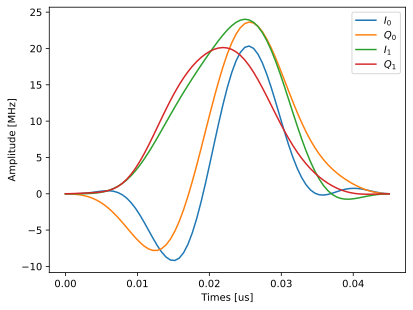

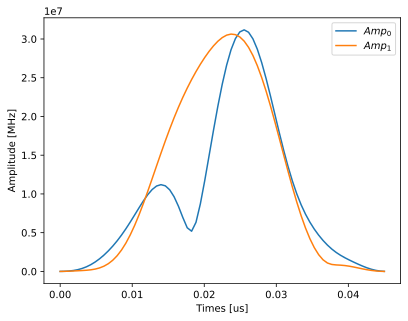

In [365]:
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_1p.filename
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_p1.filename
pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')
print(pulse_filename)

pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

plt.figure()
plt.plot(times*1e6, np.abs(I_0+1j*Q_0), label='$Amp_0$')
plt.plot(times*1e6, np.abs(I_1+1j*Q_1), label='$Amp_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

In [54]:
tomo_qubits = [0, 1] # which qubits to do tomo on

# init_state = '|0+1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
# init_state = '|1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
init_state = '|0+1>|1>' # this is just for reference when doing the 2Q tomo comparison

readout_cool = True

In [367]:
centers = [3000, 5200]
spans = [2000, 2000]
# spans = [500, 500]
npts = [6, 6]

# centers = [4100, 5100]
# spans = [0, 0]
# npts = [1, 1]

centers = np.array(centers)
spans = np.array(spans)
npts = np.array(npts)
print('number points', (npts[0]+1)*(npts[1]+1))

tomoExpt = meas.OptimalCtrlTomo2QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"OptimalCtrlTomo2Q_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    starts=(centers-spans/2).astype(int), # start gain for each qubit in IQ_qubits
    steps=(spans/npts).astype(int),
    expts=npts+1,
    reps=5000, # reps per measurement basis
    # reps=100, # reps per measurement basis
    singleshot_reps=15000, # reps for single shot calib
    # singleshot_reps=1000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    
    Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
    Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
    times_us=times_us,
    IQ_qubits=IQ_qubits,
    
    readout_cool=readout_cool,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=10,
   
    # thresholds=[530.1641328860773, 298.0622274040452, 0, 0],
    # angles=[-156.06235175077572, -177.6596617753593, 0, 0],
    # ge_avgs=[[-442.594915, -279.7363071627907, -914.3632173488371, -39.117149279069764], [-177.4867981416169, 198.44441421595226, -387.54766318502436, 200.4889138632664], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    # counts_calib=[[15698, 2664, 1281, 357], [3353, 14690, 562, 1395], [1904, 406, 14898, 2792], [820, 1603, 3297, 14280]]
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

number points 49
gainpts Q0 [2000 2333 2666 2999 3332 3665 3998]
gainpts Q1 [4200 4533 4866 5199 5532 5865 6198]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.66922230741025 	 angle (deg): 26.03327721940717 	 threshold ge: 312.0803289891335
Qubit (1)
ge fidelity (%): 53.900000000000006 	 angle (deg): -173.43104307957515 	 threshold ge: 408.0059907231424


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 80.14 	 angle (deg): 155.72747849360348 	 threshold ge: 490.2627886037599


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 75.26666666666667 	 angle (deg): 29.431008995938555 	 threshold ge: 76.64195865903628
thresholds=[312.0803289891335, 408.0059907231424, 490.2627886037599, 76.64195865903628],
angles=[26.03327721940717, -173.43104307957515, 155.72747849360348, 29.431008995938555],
ge_avgs=[[199.03519633969907, 85.0020259837963, 540.181451461227, -83.35677699652778], [-296.75081434461805, -95.21728838975694, -508.2667942274306, -68.54649733072917], [-123.88178407118056, -398.12985993923616, -510.5924571180556, -594.4715744791666], [179.27013018663197, 433.4731576171875, 500.20205553385415, 250.7809875]],
counts_calib=[[11409, 2199, 970, 422], [3815, 9681, 522, 982], [1715, 394, 9893, 2998], [817, 1527, 2300, 10356]]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [368]:
pulse_dict = tomoExpt.pulse_dict
tomoExpt.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00220_OptimalCtrlTomo2Q_01.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00220_OptimalCtrlTomo2Q_01.h5'

In [369]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

init_state |0+1>|1>
Using evol mats from file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_01.npz
2000 4200 fid 0.7900935947103881 purity 0.9264454457985281
2000 4533 fid 0.7252161930390134 purity 0.8231540847372207


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 757ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 762

2000 4866 fid 0.8096309724414746 purity 0.8898649511788913
2000 5199 fid 0.8350459024922657 purity 0.8867231663415802
2000 5532 fid 0.8672691344765677 purity 0.9323344636694888
2000 5865 fid 0.7098493244203479 purity 0.7273143716327338
2000 6198 fid 0.82624686324649 purity 0.9152988591225367
2333 4200 fid 0.8246409787190135 purity 0.9999999999999989
2333 4533 fid 0.8786613117637943 purity 0.9917800380852212
2333 4866 fid 0.8295685160958223 purity 0.7779749029279631
2333 5199 fid 0.8980605779608543 purity 0.9434951297632973
2333 5532 fid 0.8454612584773566 purity 0.84982735787441
2333 5865 fid 0.8277355548988974 purity 0.8739597963854973
2333 6198 fid 0.8006882533941494 purity 0.8561253487969542
2666 4200 fid 0.7518277412037819 purity 1.0000000000000002
2666 4533 fid 0.8515566056677963 purity 0.8583551170326805
2666 4866 fid 0.8813545311852964 purity 0.8821644736850136
2666 5199 fid 0.9007145082293949 purity 0.9316244804477191
2666 5532 fid 0.9042071647230624 purity 0.922449755467669
26

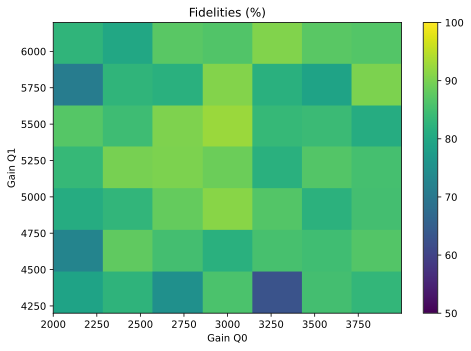

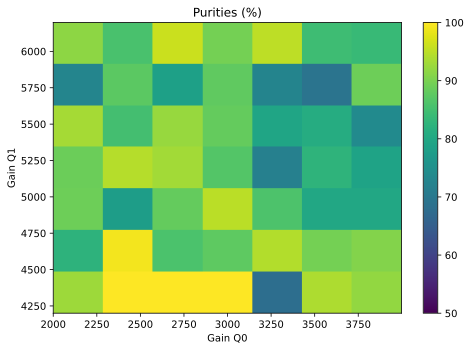

In [370]:
tomo = tomoExpt

# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
print('init_state', init_state)
rho_id = qt.ket2dm(name_to_state_2q(init_state))

# filename = 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00023_OptimalCtrlTomo2Q_01.h5'
# tomo = meas.OptimalCtrlTomo2QExperiment(config_file=config_path)
# data, attrs = prev_data(filename, None)
# tomo.data = data
# tomo.cfg = AttrDict(attrs['config'])
# pulse_dict = attrs['pulse_dict']

q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})


data = tomo.data
cfg = tomo.cfg

gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
fids_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))
purities_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))

for igain0, gain0 in enumerate(gainpts0):
    for igain1, gain1 in enumerate(gainpts1):
        if apply_ps:
            n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
                data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
                ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
                apply_ps=apply_ps, verbose=False)
        else:
            n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
            n_calib = data['counts_calib']
        
        rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
            n_tomo_raw=n_tomo_raw,
            n_calib=n_calib,
            correct_readout=True,
            correct_neg_counts=True,
            method='analytical',
            ZZ_correction=True,
            evol_mats=evol_mats,
        )
        fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
        purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
        
        fids_grid[igain1, igain0] = fid_ZZ
        purities_grid[igain1, igain0] = purity_ZZ
        print(gain0, gain1, 'fid', fid_ZZ, 'purity', purity_ZZ)

x_sweep = gainpts0
y_sweep = gainpts1

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Fidelities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(fids_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Purities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(purities_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

Pick one gain to plot tomo for

In [371]:
gain0 = 3000 # x axis
gain1 = 5532 # y axis

tomo = tomoExpt
cfg = tomo.cfg

data = tomo.data
gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
igain0 = np.argmin(np.abs(gainpts0-gain0)) 
igain1 = np.argmin(np.abs(gainpts1-gain1)) 
print('plotting at gain Q0', gainpts0[igain0], 'Q1', gainpts1[igain1])
print('expected fid', fids_grid[igain1, igain0])
print('expected purity', purities_grid[igain1, igain0])
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

if apply_ps:
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
        data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
        ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
        apply_ps=apply_ps, verbose=False)
else:
    n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
    n_calib = data['counts_calib']

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

plotting at gain Q0 2999 Q1 5532
expected fid 0.9243577344888096
expected purity 0.8820013485423933
Tomography counts
[[ 200.  836.  161.  571.]
 [ 627.  456.  336.  395.]
 [ 577.  468.  319.  404.]
 [ 429. 1115.   58.  228.]
 [ 796.  700.  122.  154.]
 [ 792.  747.  143.  159.]
 [ 310. 1176.   72.  249.]
 [ 762.  680.  137.  172.]
 [ 769.  644.  149.  166.]]
Confusion matrix counts
[[4304.  812.  154.   67.]
 [1355. 3628.   60.  173.]
 [ 376.   90. 3683. 1054.]
 [ 151.  417.  819. 3805.]]
Confusion matrix corrected tomo matrix will be
[[-153.75047 1151.69445   55.8385   714.21752]
 [ 564.15601  460.84916  343.01288  399.98195]
 [ 508.45598  503.90887  325.99543  429.63972]
 [  16.26822 1518.45078    2.36374  230.91726]
 [ 702.85297  832.61935  100.31745  132.21024]
 [ 646.30038  872.67826  126.08352  122.93783]
 [-170.35711 1661.63803   22.89941  253.81967]
 [ 673.94588  818.80759  120.05849  155.18804]
 [ 709.0675   771.88676  141.4794   145.56635]]
Negative counts corrected tomo mat

## Qram experiment

In [258]:
# tomo_qubits = [0, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 2] # which qubit/resonators to do tomo on
tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

In [259]:
save_data = False

In [260]:
init_state = '|0+1>|1>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|1>|0>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'
# init_state = '|1>|1>' # Q0/Q1 (switch, input)
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2]*8 # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

# cool_qubits = [0, 1]
cool_qubits = None

readout_cool = False

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

post_select = False # this is not the readout post selection

# add_phase = True # phase for swaps
add_phase = False
print('init_state', init_state)
print('post select', post_select)

init_state |0+1>|1>
post select False


TOMO QUBITS [0, 1]
init state |0+1>|1>


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

(64,) (64,)


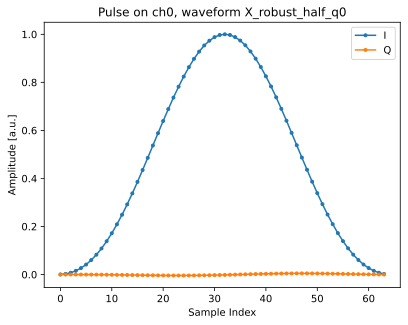

(64,) (64,)


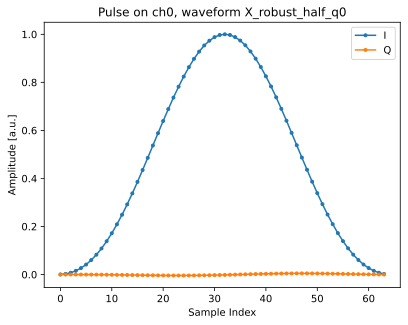

(96,) (96,)


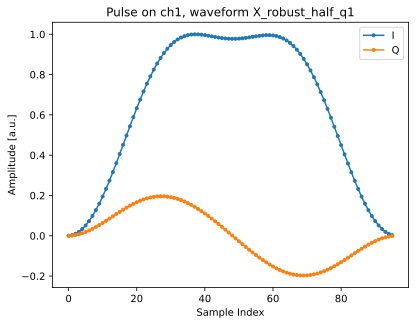

(96,) (96,)


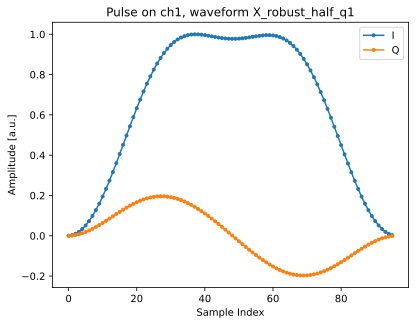

(80,) (80,)


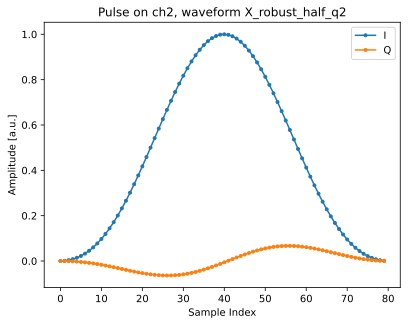

(80,) (80,)


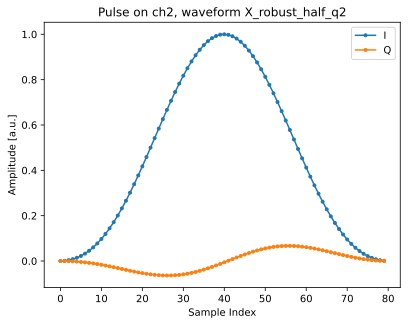

(80,) (80,)


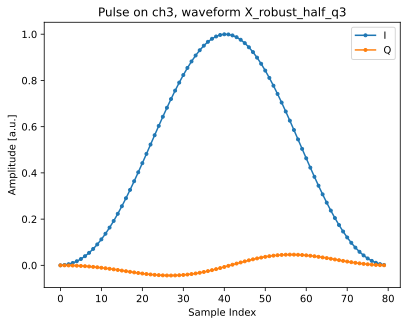

(80,) (80,)


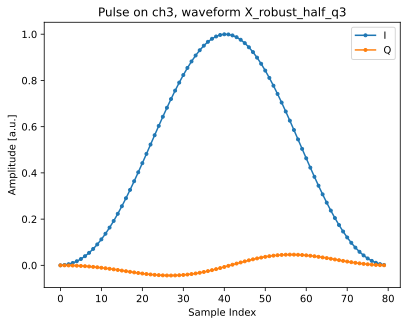

(64,) (64,)


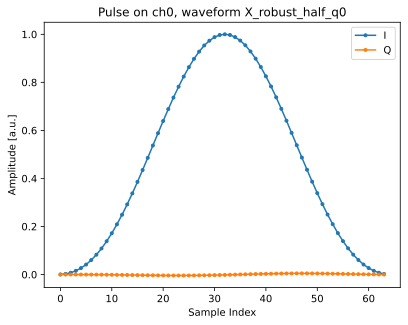

(64,) (64,)


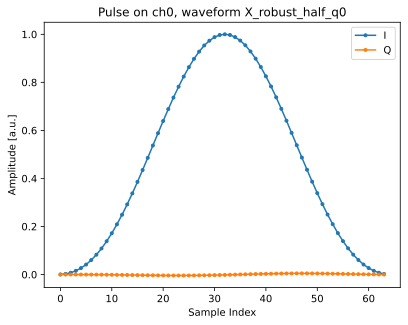

(96,) (96,)


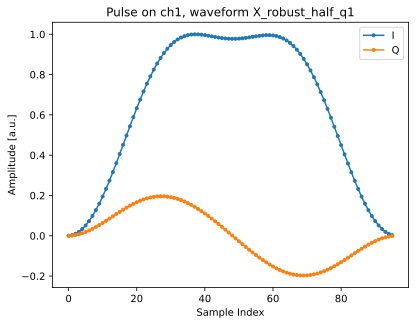

(96,) (96,)


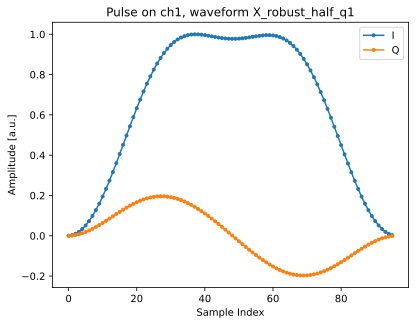

(80,) (80,)


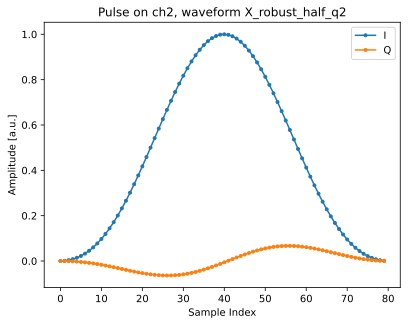

(80,) (80,)


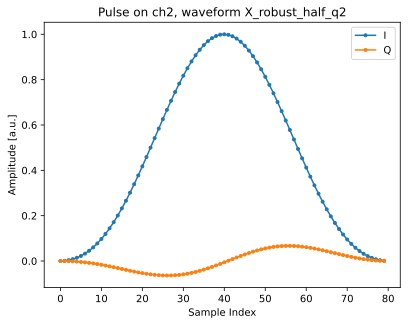

(80,) (80,)


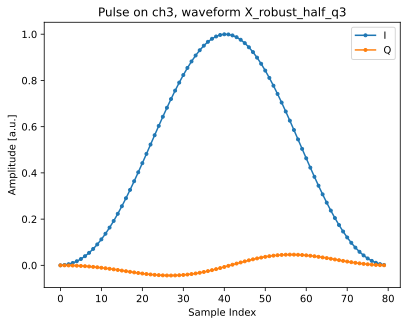

(80,) (80,)


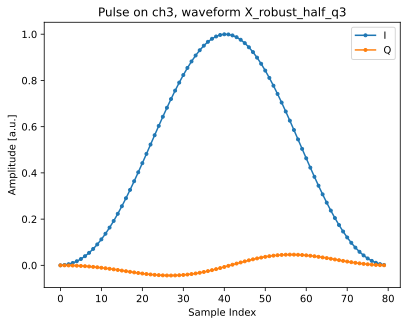

(96,) (96,)


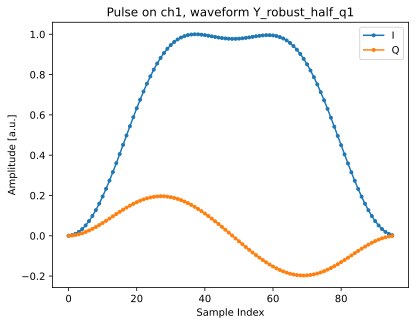

(64,) (64,)


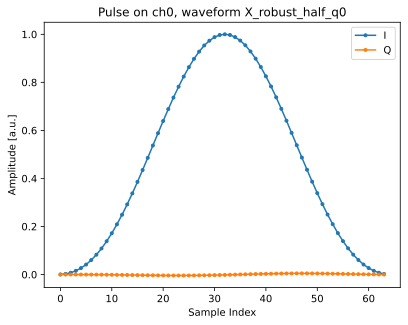

(64,) (64,)


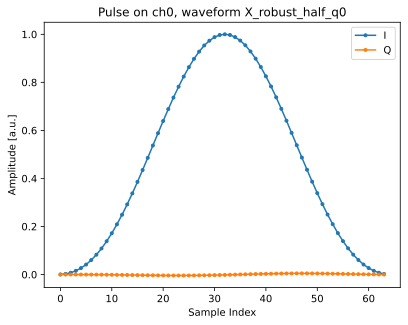

(96,) (96,)


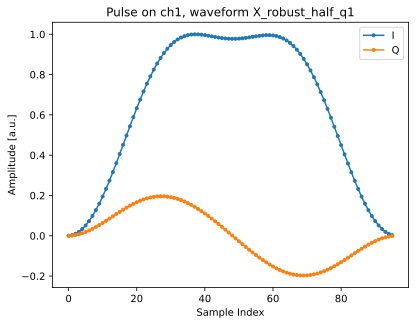

  0%|                                                                                            | 0/1 [00:14<?, ?it/s]

(96,) (96,)


KeyboardInterrupt: 

In [233]:
qramExpts = []
nrepeat = 1
print('TOMO QUBITS', tomo_qubits)
print('init state', init_state)
saved_files = []

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )

    # span = 2.161196963262976 # total time [us]
    # span = 1.1659462011134218 # total time [us]
    span = np.inf
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        reps=10000, # number of reps per time step,
        # singleshot_reps=100, # reps per state for singleshot calibration
        singleshot_reps=10000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses,
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=True,
        
        add_phase=add_phase,
        
        # readout_cool=readout_cool,
        # n_init_readout=1,
        # n_trig=1,
        # # init_read_wait_us=5,
        # init_read_wait_us=10,
        
        # Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
        # Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
        # times_us=times_us,
        # IQ_qubits=IQ_qubits,
        # IQ_gain=[3700, 3950],
        
        # thresholds=[33.169103683345895, 37.49913270024612, 0, 0],
        # angles=[-24.579056838557847, 115.19639444481155, 0, 0],
        # ge_avgs=[[34.43056101813111, -9.525004532775455, 44.589988819153874, -4.651175313807532], [30.053312459336368, -50.17723301886793, 25.548312166558233, -59.65660634352635], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
        # counts_calib=[[12553, 5207, 1604, 636], [4673, 12956, 666, 1705], [2241, 876, 12383, 4500], [918, 2095, 4712, 12275]]
 
    )

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    qramExpts.append(qramExpt)
    if save_data: saved_files.append(qramExpt.save_data())

In [152]:
qramExpt.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00008_qram_protocol.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00008_qram_protocol.h5'

### post processing average counts

In [191]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]


postselect = False # this is not the readout post selection
postselect_state = 1 # select on Q1 being 0 (-) or 1 (+)

In [192]:
cfg = qramExpt.cfg
print('init state', qramExpt.cfg.expt.init_state)
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    if postselect and qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps{postselect_state}'])
        n_calib = np.array(data['counts_calib'])
        print(f'Just getting states from post selection value of {postselect_state}')
    elif postselect and not qramExpt.cfg.expt.post_select:
        assert False, 'You are trying to post select but the experiment was not run with the post select flag=True!'
    elif qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps0'] + data[f'counts_tomo_ps1'])
        n_calib = np.array(data['counts_calib'])
    else:
        n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
    
    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)

pulse_dict = qramExpts[-1].pulse_dict
# print(pulse_dict)

init state |0+1>|1>


In [193]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
# n_tomo_corrected = tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
print('num rounds', len(n_tomo_raw_rounds))

print('Measure order', tomo_analysis.meas_order)

print('Average raw tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
# print('Std raw tomography counts')
# print(n_tomo_raw_std)
print('Average confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Corrected counts')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=3))
# print('Std confusion matrix counts')
# print(n_calib_std)
# print('Average n_tomo')
# print(n_tomo_avg)
# print('Std n_tomo')
# print(n_tomo_std)
# print('Corrected average tomo with average calib counts, corrected for neg counts')
# print(n_tomo_corrected)

# n_tomo = n_tomo_avg
# print(pulse_dict['ZX'].keys())
# print(pulse_dict['ZX']['Yhalf_q1'])
# print(pulse_dict['ZX']['Xhalf_q1'])

num rounds 1
Measure order ['ZZ' 'ZX' 'ZY' 'XZ' 'XX' 'XY' 'YZ' 'YX' 'YY']
Average raw tomography counts
[[0.1102 0.3993 0.1066 0.3839]
 [0.2332 0.2632 0.235  0.2686]
 [0.2533 0.2428 0.2592 0.2447]
 [0.171  0.6744 0.0584 0.0962]
 [0.3968 0.4357 0.0616 0.1059]
 [0.4297 0.3995 0.0852 0.0856]
 [0.1355 0.5239 0.0851 0.2555]
 [0.3067 0.3592 0.1586 0.1755]
 [0.3397 0.3258 0.1835 0.151 ]]
Average confusion matrix counts
[[0.7537 0.1462 0.0834 0.0167]
 [0.2096 0.6845 0.0234 0.0825]
 [0.0991 0.0217 0.7758 0.1034]
 [0.0264 0.1137 0.1661 0.6938]]
Corrected counts
[[-0.     0.495  0.014  0.491]
 [ 0.192  0.284  0.206  0.318]
 [ 0.224  0.252  0.242  0.281]
 [-0.     0.956  0.03   0.014]
 [ 0.372  0.544  0.006  0.078]
 [ 0.429  0.482  0.038  0.05 ]
 [-0.     0.702  0.02   0.278]
 [ 0.263  0.435  0.125  0.176]
 [ 0.319  0.379  0.161  0.141]]


 C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py: 520RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 129RuntimeWarning: Degrees of freedom <= 0 for slice
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 206RuntimeWarning: invalid value encountered in divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 163RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 198

Plot single shot blobs for various bases

In [121]:
tomo = qramExpt

In [95]:
q = 0
plot_bases = ['ZZ']

data = tomo.data
check_states = []

iprep_g = 0
if q == tomo.cfg.expt.tomo_qubits[0]: iprep_e = 2
else: iprep_e = 1
iprep_ee = 3

data['iqshots'] = []
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_g, :, -1, :], data[f'calib_qshots_raw'][iprep_g, :, -1, :]))
check_states.append('g')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_e, :, -1, :], data[f'calib_qshots_raw'][iprep_e, :, -1, :]))
check_states.append('e')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_ee, :, -1, :], data[f'calib_qshots_raw'][iprep_ee, :, -1, :]))
check_states.append('ee')

for basis in plot_bases:
    ibasis = np.where(tomo_analysis.meas_order == basis)[0][0]
    data['iqshots'].append((data[f'ishots_raw'][ibasis, :, -1, :], data[f'qshots_raw'][ibasis, :, -1, :]))
    check_states.append(basis)

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=data, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

g unrotated averages:
I 153.30682987080104 +/- 157.32054944247898 	 Q 217.1223333333333 +/- 141.3361102164992 	 Amp 301.119706597186 +/- 157.1549087492475
Rotated (theta=-0.6213754729628493):
I 251.04913741636943 +/- 170.87577995648476 	 Q 87.28930243530819 +/- 124.60786151875367 	 Amp 265.79144402547246 +/- 157.1549087492475
e unrotated averages:
I 470.169922118863 +/- 169.17283148206135 	 Q 443.9923636692506 +/- 145.78154327321593 	 Amp 660.9410711297123 +/- 176.68497510131715
Rotated (theta=-0.6213754729628493):
I 640.7570150550231 +/- 184.99926100713037 	 Q 87.28930243530819 +/- 125.08788389605972 	 Amp 646.6753239933203 +/- 176.68497510131715
ee unrotated averages:
I 449.7158577777779 +/- 173.84332881185708 	 Q 423.1998562790698 +/- 153.0774827193562 	 Amp 632.1569343699769 +/- 188.08056812829648
Rotated (theta=-0.6213754729628493):
I 612.0218123529866 +/- 196.16008314947985 	 Q 82.29077892202478 +/- 123.18863773445753 	 Amp 617.5293281225013 +/- 188.08056812829648
ZZ unrotated av

[[0.7739999999999998], [437.8966430523112], -35.60219209371666]

In [ ]:
# n_tomo = np.array( # |0>(|0+1>)
# [[7000,    0,    0,    0.],
#  [3792, 3073,  136,    0.],
#  [3970, 2784,    0,  247.],
#  [2472,    0, 4528,    0.],
#  [1411, 1199, 2044, 2346.],
#  [1533, 1196, 1949, 2322.],
#  [2195,    0, 4805,    0.],
#  [1624, 1141, 1970, 2265.],
#  [1549, 1185, 2072, 2193.]]
# )
 
# n_tomo = np.array( # |1>(|0+1>)
# [[ 971, 2621, 3408,    0.],
#  [1845, 2063, 1577, 1515.],
#  [1916, 1949, 1368, 1767.],
#  [2170,  999, 2005, 1825.],
#  [1757, 1430, 1434, 2378.],
#  [1457, 1758, 1643, 2142.],
#  [2217, 1055, 1985, 1743.],
#  [1738, 1478, 1332, 2453.],
#  [1841, 1476, 1305, 2378.]]
# )

# n_tomo = np.array( # (|0+1>)(|0+1>)
# [[3569, 1651, 1780,    0.],
#  [2896, 2730,  880,  495.],
#  [2897, 2727,  773,  603.],
#  [2200,  737, 3594,  470.],
#  [1630, 1303, 2016, 2051.],
#  [1626, 1360, 1906, 2108.],
#  [2408,  460, 3146,  987.],
#  [1430, 1641, 2026, 1904.],
#  [1478, 1387, 1767, 2368.]]
# )

# n_tomo = np.array( # (|0+i1>)(|0+1>)
# [[3163., 2173., 1664.,    0.],
#  [2438., 3299.,  806.,  456.],
#  [2627., 3226.,  722.,  425.],
#  [1857., 1092., 3028., 1023.],
#  [1242., 1632., 1695., 2431.],
#  [1469., 1365., 1518., 2647.],
#  [1980.,  885., 2896., 1239.],
#  [1300., 1627., 1468., 2605.],
#  [ 963., 1985., 1752., 2300.]])


## Big qram protocol loop!

In [270]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|1>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# init_pulse_play = [0]

tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

cool_qubits = None
# cool_qubits = [0, 1]

readout_cool = False

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

save_data = True
saved_files = []

In [271]:
play_pulses = protocol_play
for init_state in init_states:
    print('init_state', init_state, 'play pulses', play_pulses)
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=30000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=False,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=10,
    )

    import Pyro4.util
    
    try:
        qramExpt.acquire(progress=True, debug=False)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.35 	 angle (deg): -122.22427914233013 	 threshold ge: 482.4531544002761
Qubit (1)
ge fidelity (%): 58.15763596059934 	 angle (deg): 82.80013612802135 	 threshold ge: -138.16289708427269
thresholds=[482.4531544002761, -138.16289708427269, 0, 0],
angles=[-122.22427914233013, 82.80013612802135, 0, 0],
ge_avgs=[[-234.33738907838074, 184.1056884065461, -466.0831660981912, 551.7661339707149], [-1052.5645629365886, 115.35326762744434, -1025.8501404543913, -96.11720153724426], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[21475, 5406, 2441, 678], [5756, 21295, 763, 2186], [2784, 634, 22958, 3624], [896, 2667, 8508, 17929]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12985  2269 12919  1827]
ZX [7829 7483 8363 6325]
ZY [7659 7421 8374 6546]
XZ [22493  4724  2225   558]
XX [13619 12957  1770  1654]
XY [13975 13154  1517  1354]
YZ [12584  2398 13207  1811]
YX [7744 7404 8674 6178]
YY [7696 7585 8369 6350]
Saving S:\QRAM\qram_4QR2\data\data_241025\00027_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.44 	 angle (deg): -124.86291240281037 	 threshold ge: 470.4894943921373
Qubit (1)
ge fidelity (%): 61.040000000000006 	 angle (deg): 80.16031065510207 	 threshold ge: -189.63662548990885
thresholds=[470.4894943921373, -189.63662548990885, 0, 0],
angles=[-124.86291240281037, 80.16031065510207, 0, 0],
ge_avgs=[[-230.42480718346258, 174.2043297157623, -479.20769955211034, 531.3186406201551], [-1063.0069397083757, 121.46037931502204, -1024.2470328133832, -102.01249142082062], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22014, 5168, 2263, 555], [5106, 21483, 894, 2517], [2636, 730, 22575, 4059], [835, 3073, 7767, 18325]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13629 13043  1725  1603]
ZX [21667  5316  2235   782]
ZY [13058 13705  1903  1334]
XZ [7621 7348 7991 7040]
XX [11977  3212 11898  2913]
XY [7564 7355 9482 5599]
YZ [7449 7764 7663 7124]
YX [12415  2746 12296  2543]
YY [8196 6902 9741 5161]
Saving S:\QRAM\qram_4QR2\data\data_241025\00028_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.95666666666666 	 angle (deg): -125.41860386034669 	 threshold ge: 487.1423102539479
Qubit (1)
ge fidelity (%): 62.04333333333333 	 angle (deg): 80.46715346757085 	 threshold ge: -185.7698457088925
thresholds=[487.1423102539479, -185.7698457088925, 0, 0],
angles=[-125.41860386034669, 80.46715346757085, 0, 0],
ge_avgs=[[-237.8689706459948, 160.86566189491816, -496.3234007062877, 524.2964054263566], [-1061.9939809539956, 124.59708732903809, -1023.6156925059341, -103.93760835311403], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22241, 5214, 2084, 461], [4988, 22101, 749, 2162], [2807, 687, 22823, 3683], [881, 2730, 7958, 18431]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 1908  2138 13718 12236]
ZX [ 2709  1264 20752  5275]
ZY [ 2503  1358 18270  7869]
XZ [7758 9141 7713 5388]
XX [12610  4589  8362  4439]
XY [12116  4744 10448  2692]
YZ [7830 7830 7843 6497]
YX [10663  4959 10377  4001]
YY [11857  3978 10696  3469]
Saving S:\QRAM\qram_4QR2\data\data_241025\00029_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.19666666666667 	 angle (deg): -128.17159265829974 	 threshold ge: 483.294216281892
Qubit (1)
ge fidelity (%): 60.74666666666667 	 angle (deg): 80.3587314220548 	 threshold ge: -191.28767559895925
thresholds=[483.294216281892, -191.28767559895925, 0, 0],
angles=[-128.17159265829974, 80.3587314220548, 0, 0],
ge_avgs=[[-242.27022768303186, 157.2993644272179, -513.0746157795004, 501.78166416882], [-1060.3030135413135, 123.18455448174521, -1021.9031535661807, -102.85878476319657], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[21759, 5533, 2130, 578], [4905, 21637, 833, 2625], [2829, 734, 22549, 3888], [886, 3173, 7714, 18227]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3259 11973  3587 11181]
ZX [7198 7898 7188 7716]
ZY [7355 7904 6929 7812]
XZ [ 5185 20368  1579  2868]
XX [12654 13119  1941  2286]
XY [12424 13617  1453  2506]
YZ [ 4347 15985  2642  7026]
YX [10139 10252  4769  4840]
YY [ 9644 10664  4285  5407]
Saving S:\QRAM\qram_4QR2\data\data_241025\00030_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 81.00468341139019 	 angle (deg): -128.69512424914404 	 threshold ge: 476.3484355271945
Qubit (1)
ge fidelity (%): 62.84771412856881 	 angle (deg): 79.84866757737831 	 threshold ge: -195.25008200971115
thresholds=[476.3484355271945, -195.25008200971115, 0, 0],
angles=[-128.69512424914404, 79.84866757737831, 0, 0],
ge_avgs=[[-242.66424487510764, 150.59507598621877, -524.8308442377261, 502.8579932299741], [-1069.1938161297614, 128.71264133604612, -1027.8118629365886, -102.4047991183452], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22748, 4754, 2084, 414], [5372, 22154, 643, 1831], [2670, 557, 23383, 3390], [768, 2774, 7907, 18551]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [7838 7695 7857 6610]
ZX [9657 5717 8421 6205]
ZY [11973  3354 12280  2393]
XZ [13681 13117  1547  1655]
XX [15629 11318  1116  1937]
XY [21562  5198  1929  1311]
YZ [8278 9482 7528 4712]
YX [9631 7979 6292 6098]
YY [13922  3660 10335  2083]
Saving S:\QRAM\qram_4QR2\data\data_241025\00031_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.25999999999999 	 angle (deg): -130.66422459401605 	 threshold ge: 462.90656095776546
Qubit (1)
ge fidelity (%): 60.81666666666666 	 angle (deg): 80.89957082022208 	 threshold ge: -171.4579603815714
thresholds=[462.90656095776546, -171.4579603815714, 0, 0],
angles=[-130.66422459401605, 80.89957082022208, 0, 0],
ge_avgs=[[-245.88360296296298, 138.91207841515933, -535.646748957795, 476.2186034108527], [-1059.576619927659, 120.01881607324516, -1023.8845110093819, -102.80377778908104], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22276, 5111, 2173, 440], [5479, 21812, 741, 1968], [2724, 631, 23050, 3595], [917, 2667, 8424, 17992]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22301  5073  2171   455]
ZX [14021 13296  1494  1189]
ZY [14060 13239  1537  1164]
XZ [12739  2429 12983  1849]
XX [7763 7423 8492 6322]
XY [7916 7380 8568 6136]
YZ [13120  2280 12885  1715]
YX [7951 7283 8611 6155]
YY [8119 7226 8693 5962]
Saving S:\QRAM\qram_4QR2\data\data_241025\00032_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.38800646677444 	 angle (deg): -131.673750069234 	 threshold ge: 470.2376742905083
Qubit (1)
ge fidelity (%): 62.07873595786526 	 angle (deg): 80.57725506854761 	 threshold ge: -184.2027902039274
thresholds=[470.2376742905083, -184.2027902039274, 0, 0],
angles=[-131.673750069234, 80.57725506854761, 0, 0],
ge_avgs=[[-254.6358716451335, 125.47880473729545, -550.260451989664, 457.58677419465977], [-1066.0199404769978, 132.1250961681926, -1028.3598762292304, -94.80180700802532], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22788, 4749, 2039, 424], [5519, 21918, 701, 1862], [2740, 701, 22798, 3761], [858, 2828, 8252, 18062]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2797   571 23234  3398]
ZX [ 1786  1797 15105 11312]
ZY [ 1735  1819 15293 11153]
XZ [12407  2525 13236  1832]
XX [7437 7788 8286 6489]
XY [7508 7740 8290 6462]
YZ [12252  2830 12862  2056]
YX [7674 7796 8184 6346]
YY [7762 7643 8425 6170]
Saving S:\QRAM\qram_4QR2\data\data_241025\00033_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.00800013333556 	 angle (deg): -133.42059449276493 	 threshold ge: 477.08071705956746
Qubit (1)
ge fidelity (%): 62.416666666666664 	 angle (deg): 80.12502878823204 	 threshold ge: -191.43672155443403
thresholds=[477.08071705956746, -191.43672155443403, 0, 0],
angles=[-133.42059449276493, 80.12502878823204, 0, 0],
ge_avgs=[[-258.4705034108527, 125.16967403962101, -561.7642144186046, 445.6629453919036], [-1065.9048833728946, 130.804589148864, -1025.9819236803435, -98.53512134056743], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22759, 4714, 2127, 400], [5451, 22040, 713, 1796], [2838, 647, 22760, 3755], [946, 2852, 8065, 18137]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [  980  3742  5655 19623]
ZX [ 2263  2030 12602 13105]
ZY [ 2308  2070 13141 12481]
XZ [ 3834 15563  2531  8072]
XX [9952 9231 5280 5537]
XY [10094  9344  5256  5306]
YZ [ 3278 13416  2931 10375]
YX [8295 8214 6726 6765]
YY [8446 8173 6624 6757]
Saving S:\QRAM\qram_4QR2\data\data_241025\00034_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.89 	 angle (deg): -135.24235476725138 	 threshold ge: 468.3995213831604
Qubit (1)
ge fidelity (%): 61.11 	 angle (deg): 80.86236929526339 	 threshold ge: -169.2622528394047
thresholds=[468.3995213831604, -169.2622528394047, 0, 0],
angles=[-135.24235476725138, 80.86236929526339, 0, 0],
ge_avgs=[[-257.6923209991387, 117.63961603789835, -574.8254518001722, 432.1011557795004], [-1061.5257878150785, 127.11738051316831, -1025.2475783203345, -98.42639975132813], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[22826, 4674, 2121, 379], [5856, 21607, 768, 1769], [2639, 605, 23362, 3394], [910, 2995, 8330, 17765]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5746 21556  1347  1351]
ZX [14268 13046  1052  1634]
ZY [14918 12484  1703   895]
XZ [ 3661 11680  3711 10948]
XX [7601 7621 7299 7479]
XY [8225 6982 7913 6880]
YZ [ 3609 11772  3685 10934]
YX [7685 7467 7392 7456]
YY [8053 7215 7553 7179]
Saving S:\QRAM\qram_4QR2\data\data_241025\00035_qram_protocol.h5


In [272]:
print(saved_files)

['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00027_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00028_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00029_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00030_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00031_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00032_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00033_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00034_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00035_qram_protocol.h5']


In [273]:
saved_files = ['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00027_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00028_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00029_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00030_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00031_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00032_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00033_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00034_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00035_qram_protocol.h5']

### Loop analysis

In [274]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

use_ZZ_mat = True
# use_ZZ_mat = False

S:\QRAM\qram_4QR2\data\data_241025\00027_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00027_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0+1>|0>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.9811602417686084
Purity (with ZZ correction): 0.9644937728277476
Target purity: 0.9999999999999996


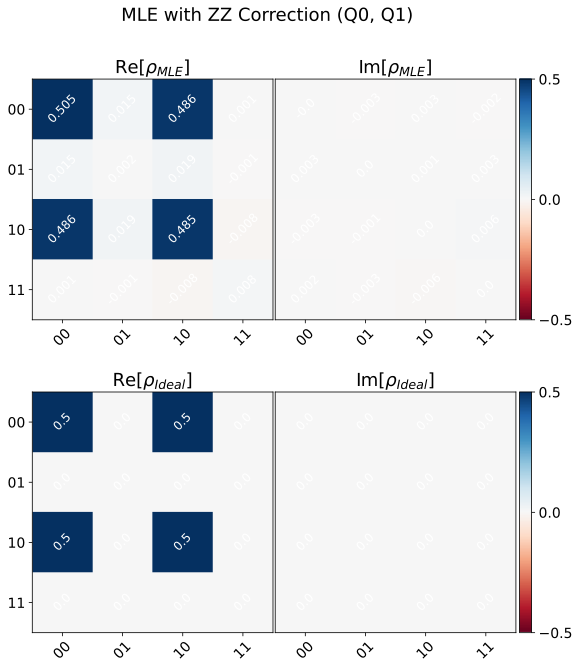





S:\QRAM\qram_4QR2\data\data_241025\00028_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00028_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0>|0+1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.9570338609267794
Purity (with ZZ correction): 0.9266065230115754
Target purity: 0.9999999999999996


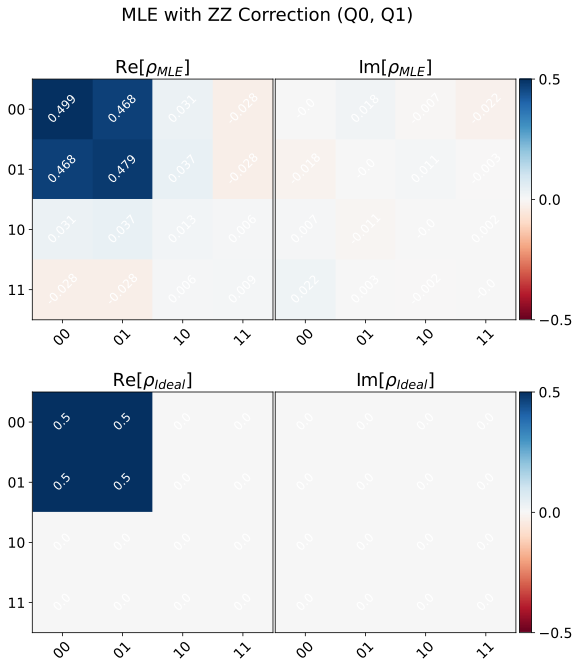





S:\QRAM\qram_4QR2\data\data_241025\00029_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00029_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |1>|0+1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.8872487184768456
Purity (with ZZ correction): 0.8549581369479692
Target purity: 0.9999999999999996


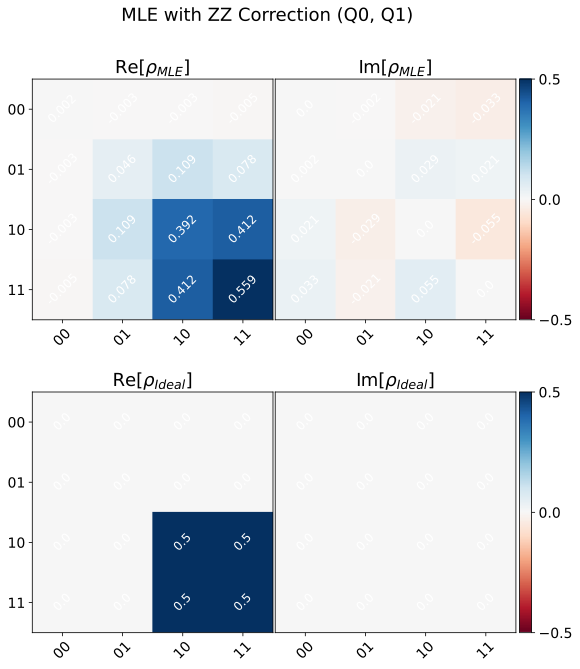





S:\QRAM\qram_4QR2\data\data_241025\00030_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00030_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0+1>|1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.9317201156282977
Purity (with ZZ correction): 0.9148369114905741
Target purity: 0.9999999999999996


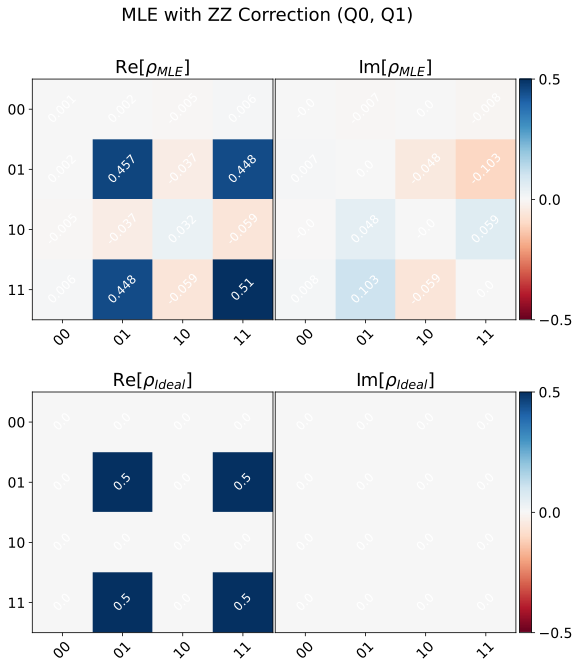





S:\QRAM\qram_4QR2\data\data_241025\00031_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00031_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0+1>|0+1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.6644736539630539
Purity (with ZZ correction): 0.9226418139052959
Target purity: 0.9999999999999991


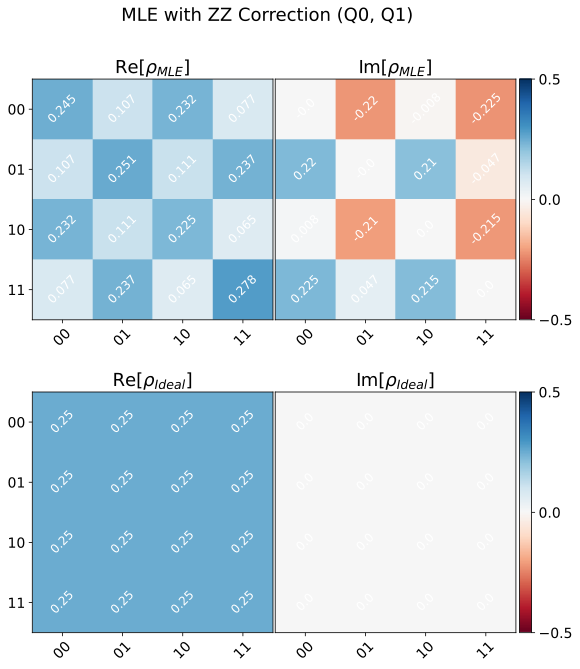





S:\QRAM\qram_4QR2\data\data_241025\00032_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00032_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0>|0>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.9908523267293917
Purity (with ZZ correction): 0.9841225113505316
Target purity: 1.0


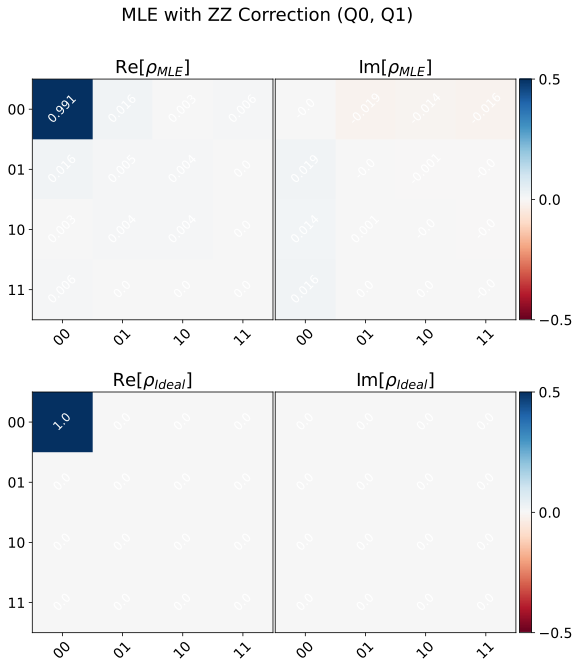





S:\QRAM\qram_4QR2\data\data_241025\00033_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00033_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |1>|0>
Fidelity (with ZZ correction): 0.9942984297033872
Purity (with ZZ correction): 0.9945001136787749
Target purity: 1.0


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

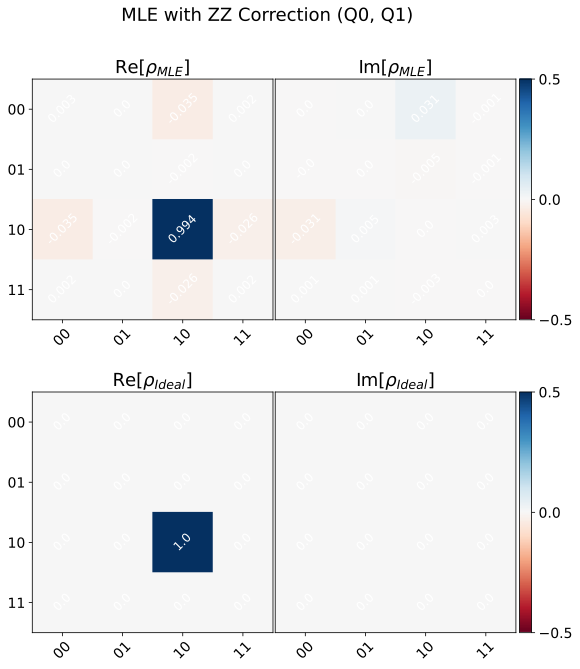





S:\QRAM\qram_4QR2\data\data_241025\00034_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00034_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |1>|1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.9208927527534355
Purity (with ZZ correction): 0.9636053281493311
Target purity: 1.0


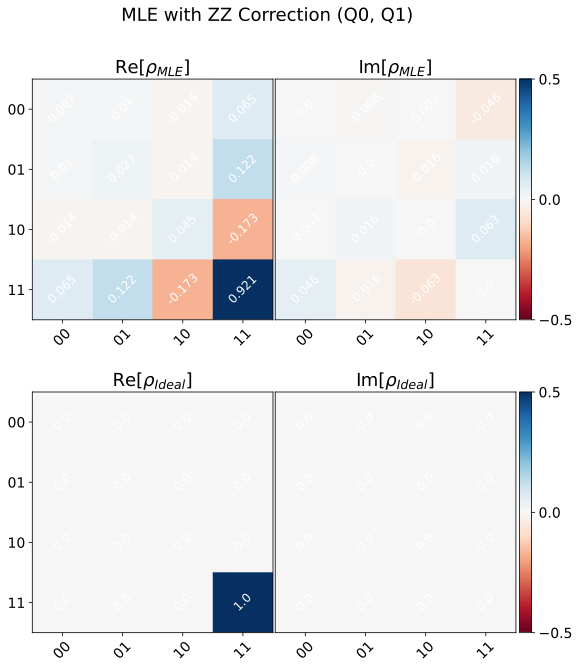





S:\QRAM\qram_4QR2\data\data_241025\00035_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00035_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0>|1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

Fidelity (with ZZ correction): 0.9399119866453028
Purity (with ZZ correction): 0.907584796055356
Target purity: 1.0


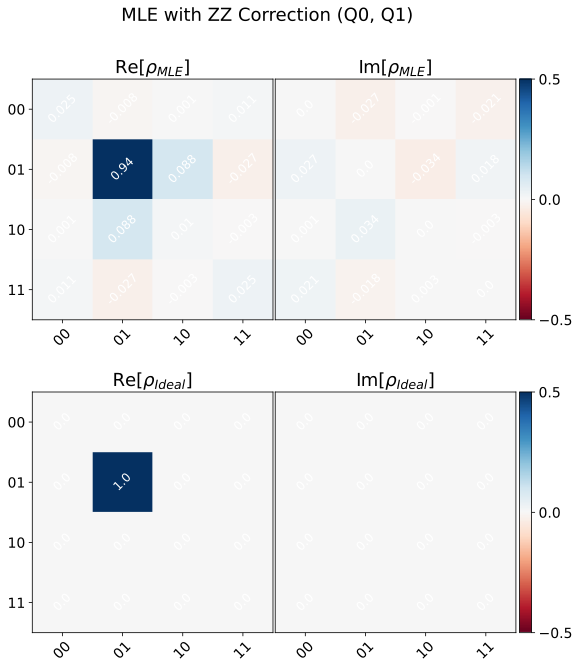

In [275]:
fidelities_ZZ = []
purities_ZZ = []
rho_MLE_ZZ_dict = dict()
init_states = []
for i_saved_file, saved_file in enumerate(saved_files):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    cfg = AttrDict(attrs['config'])
    pulse_dict = attrs['pulse_dict']
    
    # print(data.keys())
    # # data = None
    # # style.use('default')
    # # qramExpt.analyze(data=data)
    # # qramExpt.display(data=data, err=False, saveplot=True)
    # # print(data)
    
    init_state = cfg.expt.init_state
    init_states.append(init_state)
    print('init state (Q0 (switch) Q1 (input)):', init_state)
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=False)
    
    rho_id = qt.ket2dm(name_to_state_2q(init_state))
    
    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=use_ZZ_mat,
        evol_mats=evol_mats
    )

    
    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (with ZZ correction): {fid_ZZ}')
    print(f'Purity (with ZZ correction): {purity_ZZ}')
    print(f'Target purity: {purity_id}')
    
    # savetitle=saved_file[:-3]+'_ZZcorrect.svg'
    savetitle=None
    
    tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
    
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)
    rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
    
    print('\n\n\n')

In [276]:
print('init_states to be saved', rho_MLE_ZZ_dict.keys())
print('ZZ correction fidelities\n', fidelities_ZZ)
print('purities (ZZ correction)\n', purities_ZZ)

# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

init_states to be saved dict_keys(['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>'])
ZZ correction fidelities
 [0.9811602417686084, 0.9570338609267794, 0.8872487184768456, 0.9317201156282977, 0.6644736539630539, 0.9908523267293917, 0.9942984297033872, 0.9208927527534355, 0.9399119866453028]
purities (ZZ correction)
 [0.9644937728277476, 0.9266065230115754, 0.8549581369479692, 0.9148369114905741, 0.9226418139052959, 0.9841225113505316, 0.9945001136787749, 0.9636053281493311, 0.907584796055356]
Saved rho_MLE_ZZ for Q0 Q1 to file S:\QRAM\qram_4QR2\data\data_241025\202411051014_init_rhoMLE_ZZ_2Q_01.npz


In [277]:
# RETREIVE SAVED MEASURED DENSITY MATRICES AND CHECK WHAT EXPECTED QRAM STATE IS
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = 'S:\QRAM\qram_4QR2\data\data_241025\\202411051014_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q{q0} Q{q1} from file {rho_MLE_ZZ_2Q_filepath}')

test_rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        test_rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ retrieved with init_states {test_rho_MLE_ZZ_dict.keys()}')

init_state = '|1>|1>'
init_rho = test_rho_MLE_ZZ_dict[init_state]
get_qram_qSLR_state_from_rho(init_rho, output_qubits=[2, 3])

Using rho_MLE_ZZ for Q0 Q1 from file S:\Connie\experiments\qramLL_4QR2\data\data_240218\202402281619_init_rhoMLE_ZZ_2Q_01.npz


FileNotFoundError: [Errno 2] No such file or directory: 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'

## Run analysis

### Reopen old data

In [698]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [249]:
filename = 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00009_qram_protocol.h5'
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
saved_files = [filename]

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
# print(cfg.device.readout)
init_state = cfg.expt.init_state
tomo_qubits = cfg.expt.tomo_qubits
play_pulses = cfg.expt.play_pulses
print('init_state', init_state)
print('tomo_qubits', tomo_qubits)
print('play_pulses', play_pulses)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])
print('counts_calib')
n_calib = n_calib.astype(np.float64)
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)

print('n_tomo_raw')
n_tomo_raw = n_tomo_raw.astype(np.float64)
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)

print('n tomo corrected')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=10))

S:\QRAM\qram_4QR2\data\data_241025\00009_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
dict_keys(['amps', 'angles', 'avgi', 'avgi_err', 'avgq', 'avgq_err', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'phases', 'qshots_raw', 'thresholds', 'xpts'])
init_state |0+1>|0>
tomo_qubits [0, 1]
play_pulses [0]
calib_order ['gg', 'ge', 'eg', 'ee']
meas_order ['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY']
counts_calib
[[0.74046667 0.1621     0.07916667 0.01826667]
 [0.3131     0.57746667 0.0281     0.08133333]
 [0.08783333 0.02663333 0.73526667 0.15026667]
 [0.03406667 0.07636667 0.1541     0.73546667]]
n_tomo_raw
[[0.3956     0.10346667 0.41916667 0.08176667]
 [0.2833     0.21386667 0.2641     0.23873333]
 [0.28246667 0.21446667 0.2673     0.23576667]
 [0.72816667 0.16256667 0.08666667 0.0226    ]
 [0.503      0.39213333 0.05433333 0.05053333]
 [0.51026667 0.38683333 0.05406667 0.04883333]
 [0.3954     0.1025     0.42146667 0.08063333]
 [0.27176

### Set ideal rho

Get final qram state from an arbitrary 2Q input density matrix

In [205]:
print('init state Q0 (switch) Q1 (input):', init_state)

init_rho = qt.ket2dm(name_to_state_2q(init_state))
rho_id = init_rho

# print('play_pulses', play_pulses)
# assert (np.all([q in [0, 2, 3] for q in tomo_qubits]) and play_pulses==[2, 1, 4, 3]), 'Automatic ideal rho calculation not available'
# init_rho = init_rho.full()
# rho_id = get_qram_qSLR_state_from_rho(init_rho, output_qubits=tomo_qubits)
rho_id

init state Q0 (switch) Q1 (input): |0+1>|0>


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.5 0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.5 0. ]
 [0.  0.  0.  0. ]]

In [85]:
# rho_id = (qt.ket2dm(psi01) + qt.ket2dm(psi10)).unit()
# rho_id = qt.ket2dm((psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi01 + psi11).unit())
# rho_id = qt.ket2dm((psi00 + psi10).unit())
# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi00+psi01).unit())
rho_id = qt.ket2dm((psi10).unit())

### Generate test data

In [246]:
rho_id = qt.ket2dm(psi00 + psi01).unit()

n_tomo_raw = tomo_analysis.generate_counts(rho_id=rho_id, n_tot=20000, evol_mats=evol_mats, noise=None)
n_calib = qt.qeye(4).full()

Generating with evol mats


### Run MLE without ZZ correction

Fidelity (no ZZ correction): 0.2069447414743584
Purity (no ZZ correction): 0.9083465861069306
[[ 0.461-0.j    -0.03 +0.008j  0.461+0.026j  0.009+0.028j]
 [-0.03 -0.008j  0.012+0.j    -0.043+0.008j  0.008+0.007j]
 [ 0.461-0.026j -0.043-0.008j  0.512-0.j     0.014+0.002j]
 [ 0.009-0.028j  0.008-0.007j  0.014-0.002j  0.015+0.j   ]]


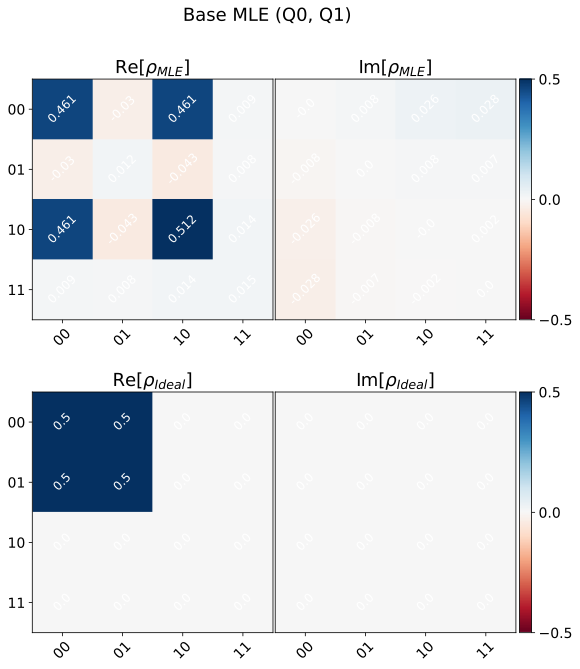

In [250]:
rho_MLE_base = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
    evol_mats=None
)

fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=id2q.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
tomo_analysis.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', cmax=0.5)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [207]:
# Recover old config
yaml_cfg = AttrDict(attrs['config'])

In [208]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [266]:
# evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

q0, q1 = tomo_qubits
# evol_mats_filename = f'evol_mats_{q0}{q1}_test.npz'
evol_mats_filename = f'evol_mats_{q0}{q1}.npz'

# evol_mats_filename += '_test'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\QRAM\qram_4QR2\evol_mats
Will save to filename evol_mats_01.npz


TOMO QUBITS [0, 1]
HAMILTONIAN QUBITS [0 1]
qubit freqs [4111.09786656 3448.47856223]
alphas [-226.47095044 -100.39312905]
ZZs (MHz) [[ 0.         -5.2589618 ]
 [-5.60299012  0.        ]]
Will save to filename evol_mats_01.npz


  0%|          | 0/9 [00:00<?, ?it/s]

ZZ
init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]
init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]]
init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]]

ZX


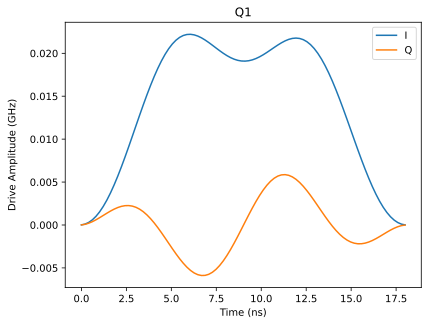

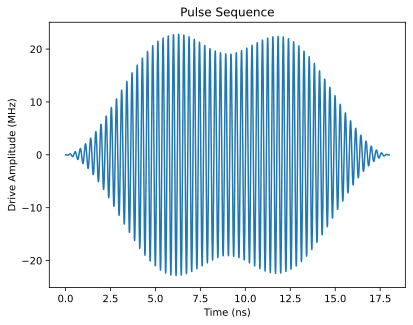

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.70201205+0.01349759j]
 [-0.70169696+0.12090602j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.49198389147813965
ge probabilty 0.5059487350425516
eg probabilty 0.0
ee probabilty 0.0


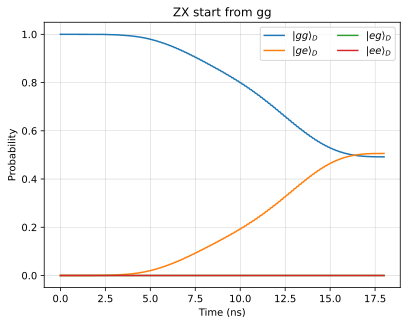

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.71177334+0.00437269j]
 [0.69072117-0.12752982j]
 [0.        +0.j        ]
 [0.        +0.j        ]]
from ge
gg probabilty 0.5063884913785879
ge probabilty 0.49311427594277496
eg probabilty 0.0
ee probabilty 0.0


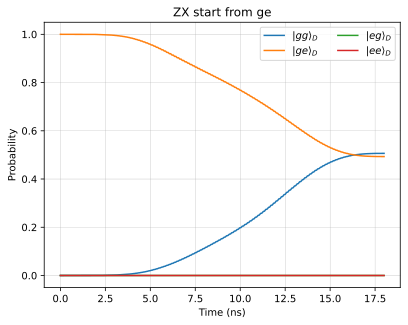

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.70316574-0.03017668j]
 [-0.70307881-0.10162421j]]
from eg
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.49492837236892556
ee probabilty 0.5042150113181881


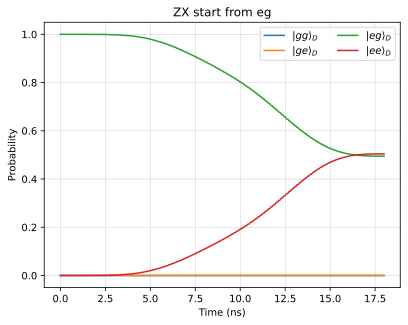

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.67510324+0.22152517j]
 [0.615895  +0.3403462j ]]
from ee
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.5045690360835091
ee probabilty 0.4948985919887951


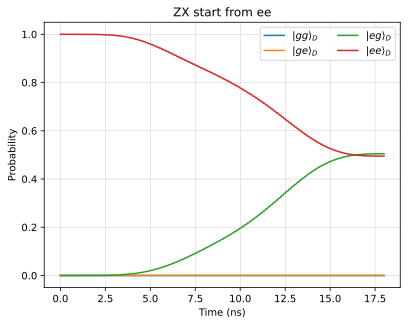


ZY


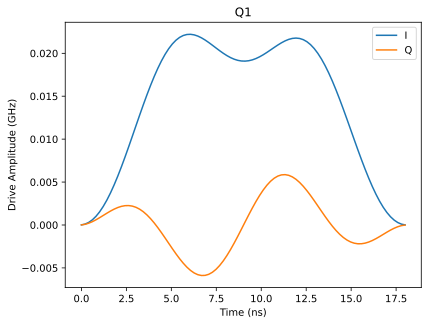

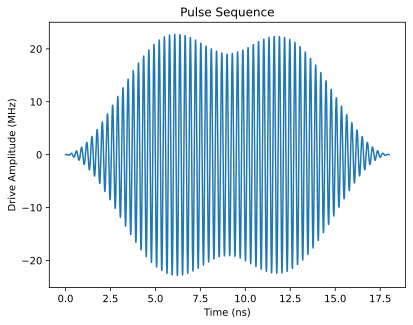

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.70201052+0.01349613j]
 [-0.120905  -0.70169869j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.49198173536069745
ge probabilty 0.5059509459165085
eg probabilty 0.0
ee probabilty 0.0


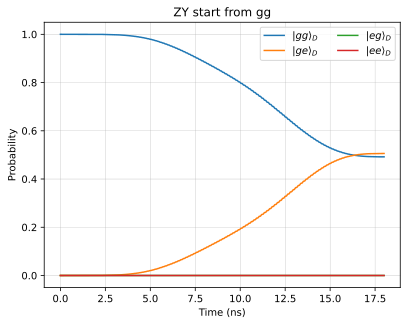

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.0043715-0.71177486j]
 [0.6907199-0.12752816j]
 [0.       +0.j        ]
 [0.       +0.j        ]]
from ge
gg probabilty 0.5063906417906393
ge probabilty 0.4931120965238805
eg probabilty 0.0
ee probabilty 0.0


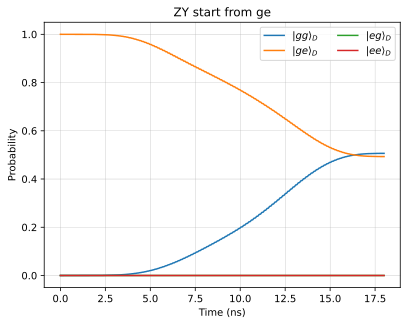

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.70316469-0.03017871j]
 [0.1016251 -0.70307964j]]
from eg
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.49492703828362133
ee probabilty 0.5042163674294168


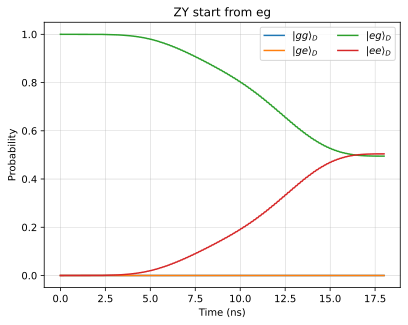

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.22152489-0.67510423j]
 [0.61589322+0.34034765j]]
from ee
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.504570270338614
ee probabilty 0.49489740741128424


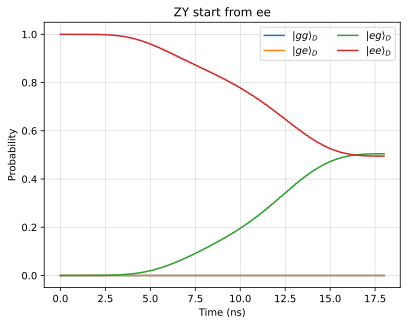


XZ


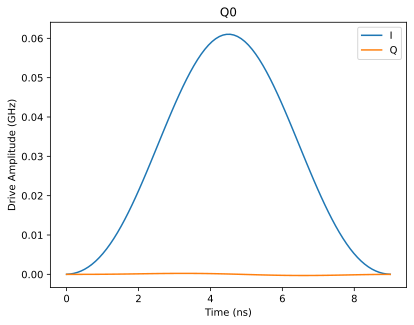

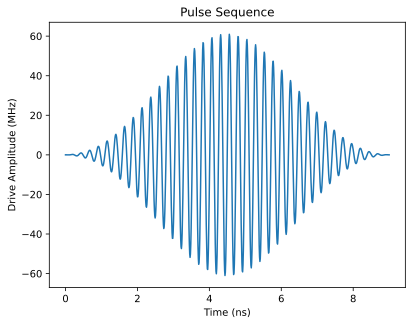

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.70116287+0.00561014j]
 [ 0.        +0.j        ]
 [-0.70164899+0.12660109j]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.4901572474134685
ge probabilty 0.0
eg probabilty 0.5067845412579612
ee probabilty 0.0


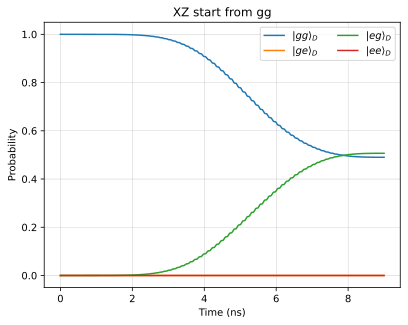

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.        +0.j        ]
 [ 0.7007951 -0.0124069j ]
 [ 0.        +0.j        ]
 [-0.71307517+0.01600145j]]
from ge
gg probabilty 0.0
ge probabilty 0.49019603094300757
eg probabilty 0.0
ee probabilty 0.5076224808855625


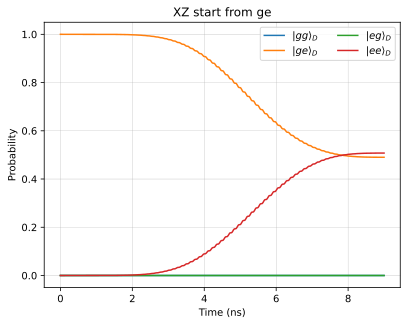

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.71231377+0.00443814j]
 [0.        +0.j        ]
 [0.69018232-0.12742737j]
 [0.        +0.j        ]]
from eg
gg probabilty 0.5069714347230033
ge probabilty 0.0
eg probabilty 0.4921630321640871
ee probabilty 0.0


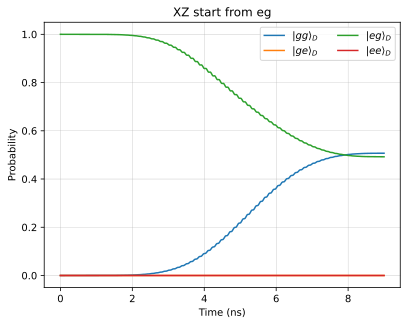

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.        +0.j        ]
 [0.70342688+0.11519825j]
 [0.        +0.j        ]
 [0.69282338+0.10915915j]]
from ee
gg probabilty 0.0
ge probabilty 0.507800779113919
eg probabilty 0.0
ee probabilty 0.49164960398357166


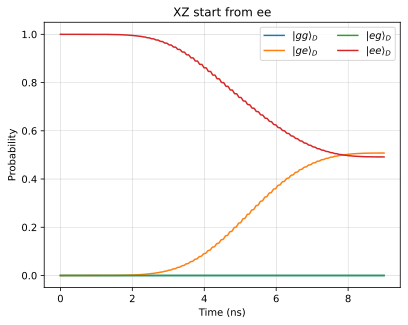


XX


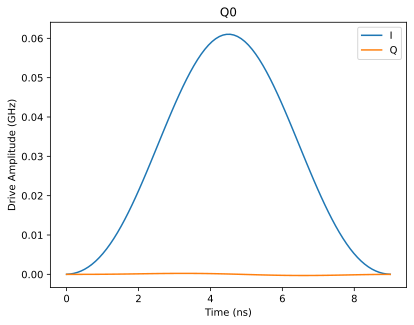

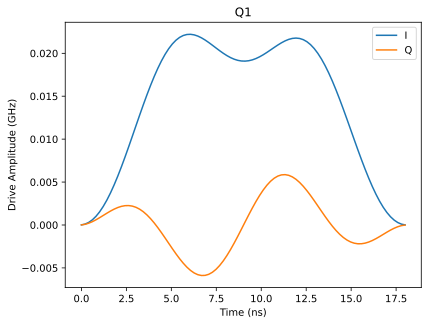

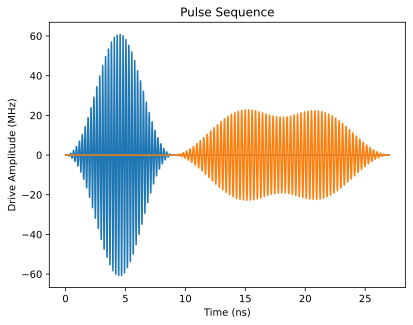

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.4920315 +0.01340599j]
 [-0.4835818 +0.12439695j]
 [-0.4895494 +0.11024164j]
 [ 0.50264388-0.06274212j]]
from gg
gg probabilty 0.24118359920673604
ge probabilty 0.24820308807253935
eg probabilty 0.25067776166868755
ee probabilty 0.25543186202043744


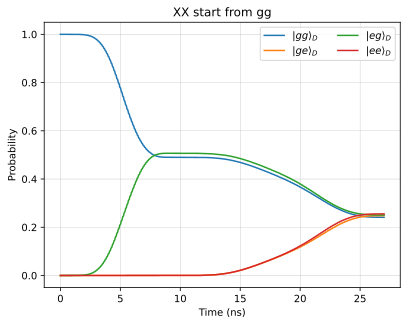

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49745527+0.03859103j]
 [ 0.48266386-0.09806671j]
 [-0.46979784-0.18963635j]
 [-0.44455355-0.23273944j]]
from ge
gg probabilty 0.24827988545621346
ge probabilty 0.24192752175076232
eg probabilty 0.2559800112565679
ee probabilty 0.25111670682968634


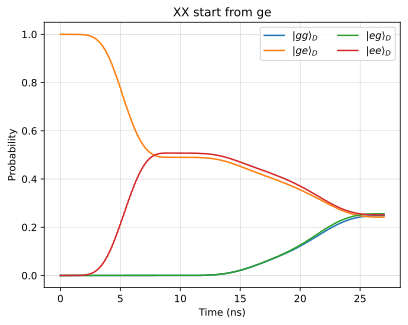

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49988894+0.01273426j]
 [-0.49105001+0.12724427j]
 [ 0.4814555 -0.11047067j]
 [-0.49452913+0.06376053j]]
from eg
gg probabilty 0.2494671652114631
ge probabilty 0.2567202889694726
eg probabilty 0.24343334876069633
ee probabilty 0.24804385378639135


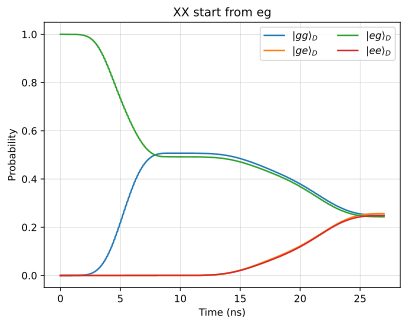

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.4907001 +0.12919922j]
 [0.50077866-0.01022594j]
 [0.42145293+0.26562601j]
 [0.38948123+0.30292195j]]
from ee
gg probabilty 0.25720498013986065
ge probabilty 0.2506168106419591
eg probabilty 0.2479155973767097
ee probabilty 0.2431982062826569


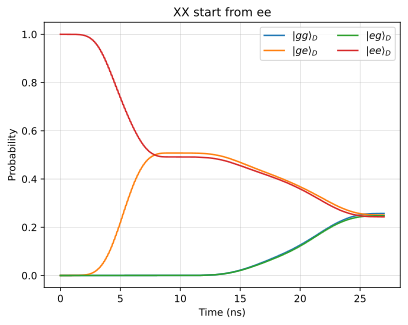


XY


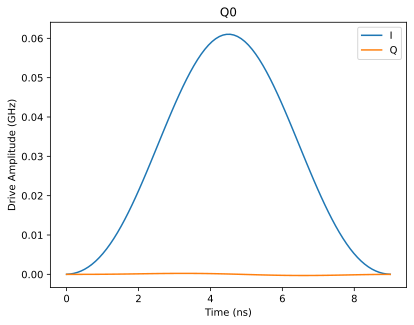

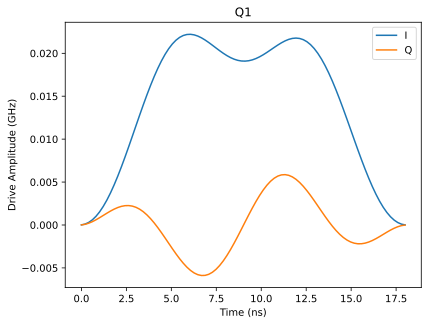

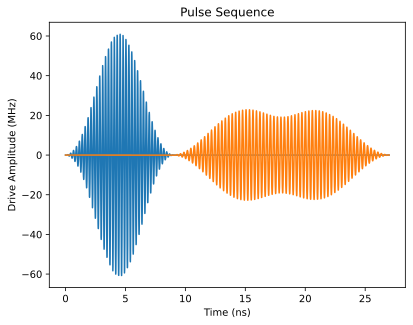

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49203109+0.01340558j]
 [-0.12439569-0.48358256j]
 [-0.48954903+0.11024211j]
 [ 0.06274129+0.50264421j]]
from gg
gg probabilty 0.2411832190548864
ge probabilty 0.24820353755136973
eg probabilty 0.2506775418189081
ee probabilty 0.2554321218905154


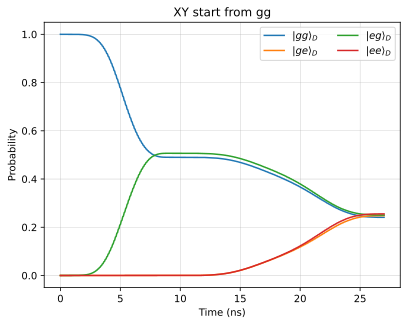

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.03858969-0.4974557j ]
 [ 0.4826636 -0.09806627j]
 [-0.18963553+0.46979836j]
 [-0.4445532 -0.23273972j]]
from ge
gg probabilty 0.24828018782304123
ge probabilty 0.24192716721757007
eg probabilty 0.2559801672868688
ee probabilty 0.2511165080827678


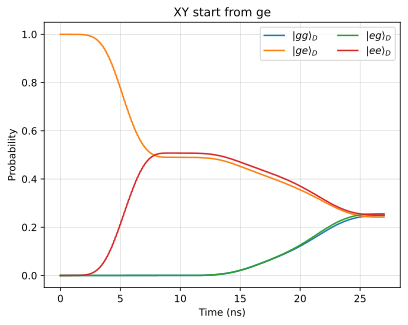

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.4998885 +0.01273384j]
 [-0.12724299-0.4910508j ]
 [ 0.48145513-0.11047112j]
 [-0.06375972-0.49452948j]]
from eg
gg probabilty 0.24946675327622814
ge probabilty 0.256720772324332
eg probabilty 0.24343311799213324
ee probabilty 0.2480441234064365


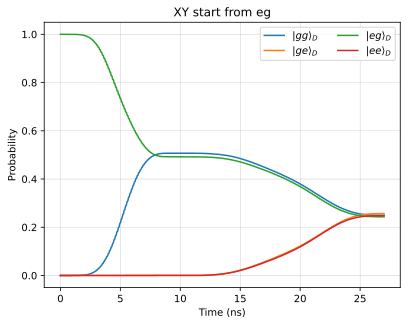

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.12919797-0.49070077j]
 [0.50077833-0.01022555j]
 [0.26562541-0.42145352j]
 [0.38948078+0.30292226j]]
from ee
gg probabilty 0.2572052845423532
ge probabilty 0.25061644003428746
eg probabilty 0.2479157505625182
ee probabilty 0.24319802155820613


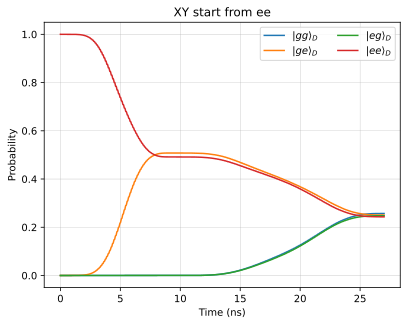


YZ


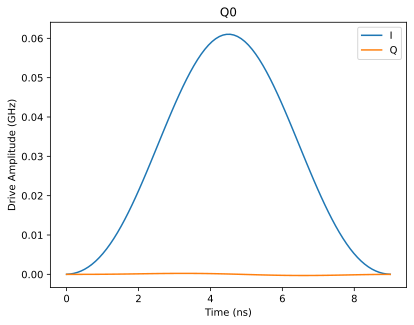

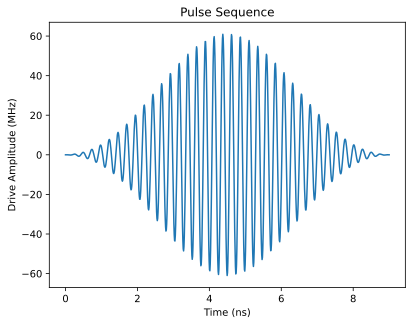

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.70116325+0.00560623j]
 [ 0.        +0.j        ]
 [-0.12660117-0.70164861j]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.49015760738192704
ge probabilty 0.0
eg probabilty 0.5067839051897367
ee probabilty 0.0


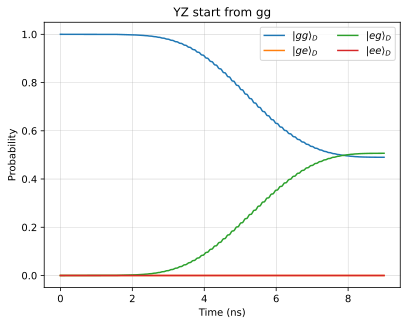

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.        +0.j        ]
 [ 0.70079606-0.01241091j]
 [ 0.        +0.j        ]
 [-0.0160019 -0.71307415j]]
from ge
gg probabilty 0.0
ge probabilty 0.4901973625449431
eg probabilty 0.0
ee probabilty 0.5076209226448777


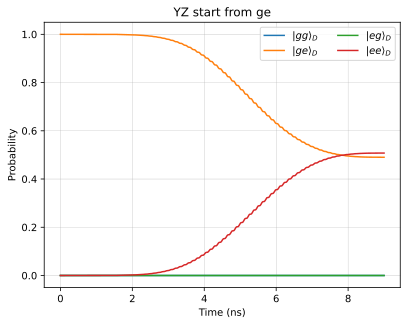

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.00443823-0.71231333j]
 [0.        +0.j        ]
 [0.69018349-0.12742351j]
 [0.        +0.j        ]]
from eg
gg probabilty 0.5069708501397336
ge probabilty 0.0
eg probabilty 0.4921636913260224
ee probabilty 0.0


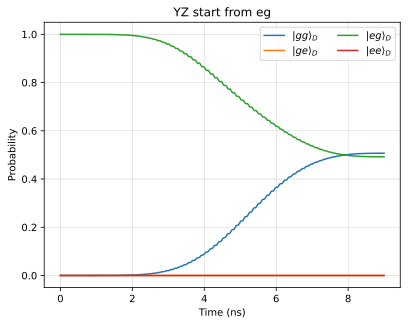

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.        +0.j        ]
 [0.11519857-0.70342572j]
 [0.        +0.j        ]
 [0.6928238 +0.10916352j]]
from ee
gg probabilty 0.0
ge probabilty 0.5077992726280952
eg probabilty 0.0
ee probabilty 0.4916511884912831


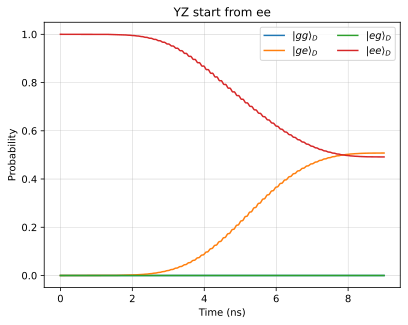


YX


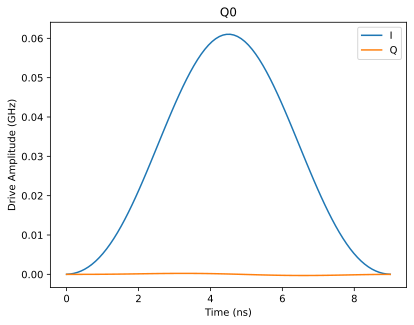

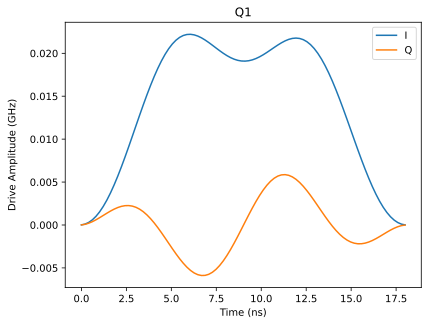

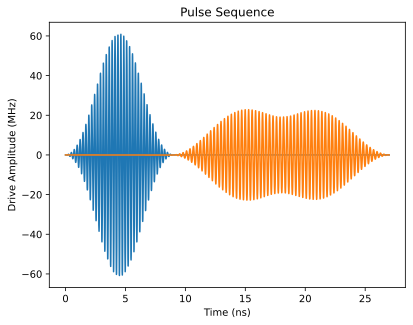

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49203184+0.01340325j]
 [-0.48358138+0.12439971j]
 [-0.11024169-0.48954912j]
 [ 0.06274219+0.50264361j]]
from gg
gg probabilty 0.2411837913957117
ge probabilty 0.24820328636012706
eg probabilty 0.250677430219757
ee probabilty 0.255431524642618


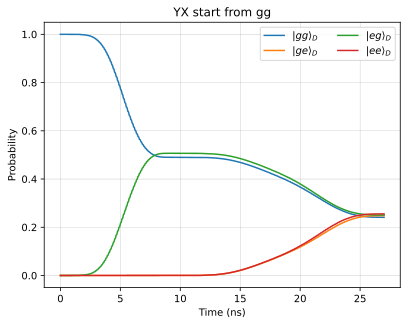

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.49745622+0.03858829j]
 [0.48266402-0.09806956j]
 [0.18963581-0.46979728j]
 [0.23273886-0.44455305j]]
from ge
gg probabilty 0.24828056090379527
ge probabilty 0.24192818042422343
eg probabilty 0.2559792237829902
ee probabilty 0.25111593476455635


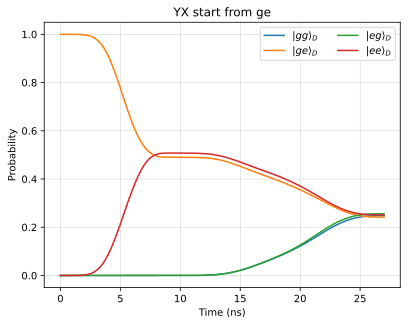

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.0127342 -0.49988863j]
 [ 0.12724424+0.4910497j ]
 [ 0.48145642-0.11046809j]
 [-0.49452979+0.06375785j]]
from eg
gg probabilty 0.24946688116430218
ge probabilty 0.2567199961166872
eg probabilty 0.24343367490724707
ee probabilty 0.2480441855583045


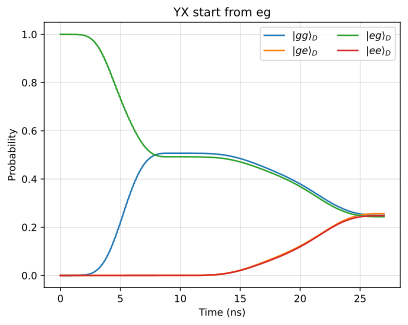

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.12919927-0.4906993j ]
 [-0.01022568-0.50077791j]
 [ 0.42145201+0.26562892j]
 [ 0.38948004+0.30292473j]]
from ee
gg probabilty 0.25720422377179486
ge probabilty 0.250616072875072
eg probabilty 0.2479163912772251
ee probabilty 0.24319898421391828


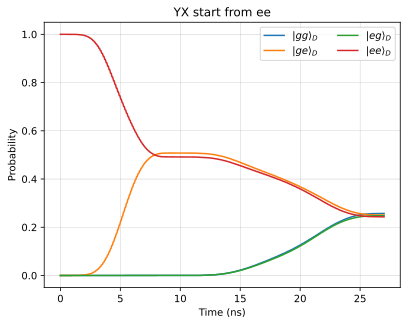


YY


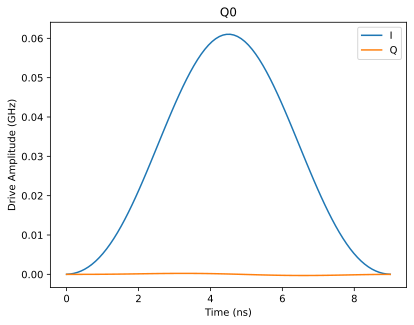

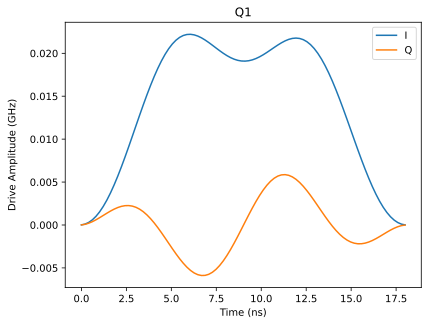

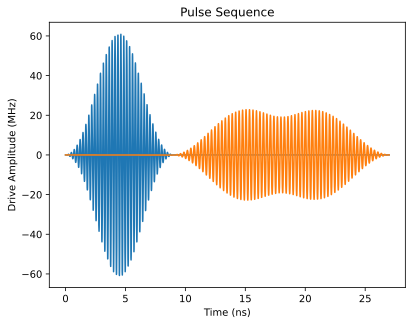

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49203144+0.01340285j]
 [-0.12439845-0.48358214j]
 [-0.11024215-0.48954876j]
 [-0.50264394+0.06274136j]]
from gg
gg probabilty 0.2411834112434808
ge probabilty 0.24820373583946811
eg probabilty 0.2506772103699256
ee probabilty 0.2554317845126785


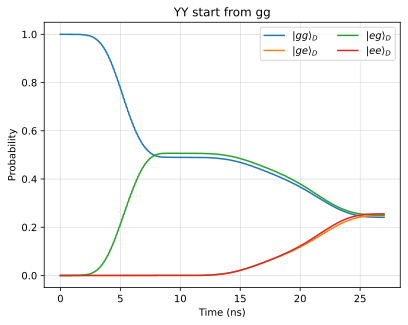

init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.03858696-0.49745666j]
 [ 0.48266377-0.09806913j]
 [-0.4697978 -0.18963499j]
 [ 0.23273914-0.4445527j ]]
from ge
gg probabilty 0.24828086327151352
ge probabilty 0.24192782589023998
eg probabilty 0.2559793798129229
ee probabilty 0.2511157360179747


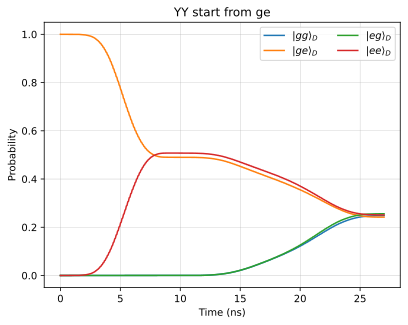

init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.01273379-0.4998882j ]
 [-0.49105049+0.12724296j]
 [ 0.48145604-0.11046854j]
 [-0.06375703-0.49453014j]]
from eg
gg probabilty 0.24946646916355572
ge probabilty 0.2567204794142405
eg probabilty 0.24343344417469467
ee probabilty 0.2480444552264024


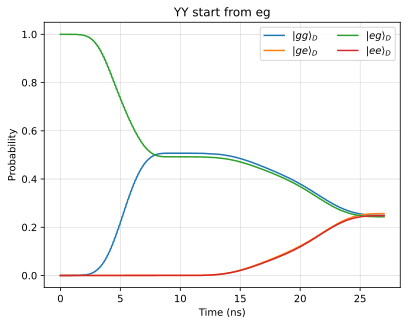

init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[-0.49069997-0.12919802j]
 [-0.01022528-0.50077758j]
 [ 0.26562832-0.42145261j]
 [ 0.38947959+0.30292504j]]
from ee
gg probabilty 0.25720452817339445
ge probabilty 0.2506157022682305
eg probabilty 0.24791654446377173
ee probabilty 0.24319879948886788


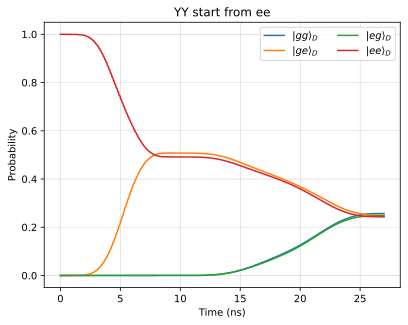


Saved evol mats to file S:\QRAM\qram_4QR2\evol_mats\evol_mats_01.npz


In [267]:
evol_mats = tomo_analysis.get_evol_mats_from_yaml(
    tomo_qubits=tomo_qubits,
    yaml_cfg=yaml_cfg,
    pulse_dict=pulse_dict,
    cutoffs=[4]*(len(tomo_qubits)),
    soccfg=soc,
    debug=True,
    evol_mats_path=evol_mats_path,
    evol_mats_filename=evol_mats_filename,
)

Reload evol mats

In [140]:
q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_01.npz


#### (Actually) run MLE with ZZ correction

init state |0+1>|0>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

[[ 0.458-0.j    -0.038+0.02j   0.452+0.026j  0.001+0.039j]
 [-0.038-0.02j   0.016-0.j    -0.057-0.005j  0.007+0.01j ]
 [ 0.452-0.026j -0.057+0.005j  0.507-0.j     0.012+0.009j]
 [ 0.001-0.039j  0.007-0.01j   0.012-0.009j  0.019-0.j   ]]
list format [[(0.458-0j), (-0.038+0.02j), (0.452+0.026j), (0.001+0.039j)], [(-0.038-0.02j), (0.016-0j), (-0.057-0.005j), (0.007+0.01j)], [(0.452-0.026j), (-0.057+0.005j), (0.507-0j), (0.012+0.009j)], [(0.001-0.039j), (0.007-0.01j), (0.012-0.009j), (0.019-0j)]]
Fidelity (with ZZ correction): 0.19893338710004216
Purity (with ZZ correction): 0.8910721922930683
Target purity: 1.0


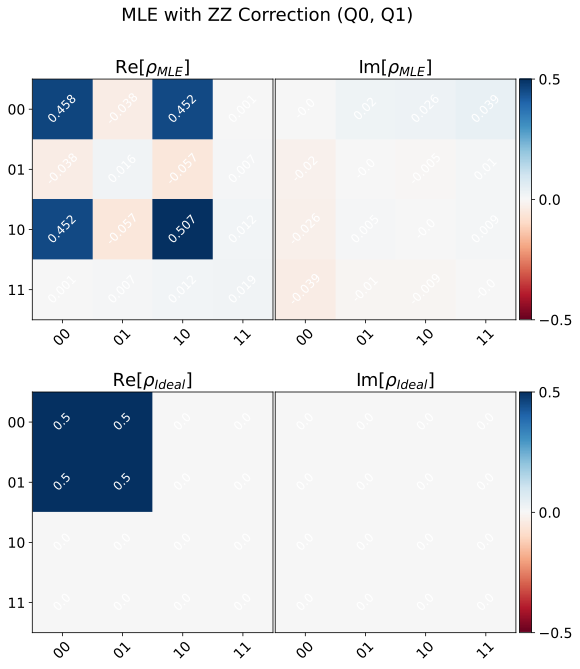

Saved svg: None
Saved data:
S:\QRAM\qram_4QR2\data\data_241025\00009_qram_protocol.h5


In [251]:
print('init state', init_state)
# print('post selection', postselect)
# if postselect: print('post select state', postselect_state)

rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

print(np.around(rho_MLE_ZZ, decimals=3))
print('list format', np.around(rho_MLE_ZZ, decimals=3).tolist())
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
# savetitle=saved_files[-1][:-3]+'_ZZcorrect.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
print('Saved svg:', savetitle)

print('Saved data:')
print(*saved_files)

Save measured density matrices

In [ ]:
rho_MLE_ZZ_dict = dict()
rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
q0, q1 = tomo_qubits

# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

### Optimize over virtual Z gate on rho_id

In [ ]:
phis = [None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
rho_MLE = rho_MLE_ZZ
rho_MLE_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)

z_phi12 = z_gate_2q(*best_phis)
rho_MLE_rot = (z_phi12*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi12.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)

In [ ]:
# tomo.save_data()